In [7]:
!pip install pdpbox
from pdpbox import pdp, info_plots

     |████████████████████████████████| 57.7 MB 52.8 MB/s eta 0:00:01    |██████                          | 10.9 MB 2.3 MB/s eta 0:00:21     |██████████████▌                 | 26.1 MB 23.3 MB/s eta 0:00:02
  Created wheel for pdpbox: filename=PDPbox-0.2.0-py3-none-any.whl size=57690722 sha256=54065c094d0c51b973679511a909248aef1672b2ff297d9865dfcd142815a17c
  Stored in directory: /root/.cache/pip/wheels/23/d4/d0/7c7a2adaab2fa7c7108e86c0eb7272fa8e2cd0b6b6732d2e15
Successfully built pdpbox


In [3]:
%matplotlib inline

from joblib import dump, load
import itertools
import json
import math
import os
import random
import time
from typing import Callable, Dict, List

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# scikit-learn
import sklearn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, mean_squared_error, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC

# statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

# Tensorflow


# NLP
import gc
import re
import string
import operator
from collections import defaultdict




# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [95]:
#read from google drive
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1H_-mi6NzeZt1PhcanHofcf3H6UiItmxO')

In [9]:
df

,user_id,source,device,operative_system,lat,long,weekday,yearweek,converted
0,3,seo_facebook,web,mac,38.89,-94.81,Friday,16,0
1,9,seo-google,mobile,android,41.68,-72.94,Friday,18,0
2,14,friend_referral,mobile,iOS,39.74,-75.53,Saturday,13,0
3,16,ads-google,mobile,android,37.99,-121.80,Friday,21,0
4,19,ads-google,mobile,android,41.08,-81.52,Wednesday,14,0
...,...,...,...,...,...,...,...,...,...
275611,999978,direct_traffic,mobile,android,39.78,-86.15,Saturday,20,0
275612,999979,direct_traffic,web,windows,31.10,-97.72,Friday,19,0
275613,999992,ads_facebook,web,windows,40.77,-74.03,Saturday,19,0
275614,999993,ads_facebook,web,windows,39.04,-95.69,Wednesday,11,0


In [20]:
def get_types(df):
    dtypes = defaultdict(list)
    for col, dtype in df.dtypes.items():
        dtypes[str(dtype)].append(col)
    return dtypes

for col in ['source', 'device', 'operative_system', 'weekday']:
    df[col] = df[col].astype('category')

dtypes = get_types(df)
dtypes

defaultdict(list,
            {'int64': ['user_id', 'yearweek', 'converted'],
             'category': ['source', 'device', 'operative_system', 'weekday'],
             'float64': ['lat', 'long']})

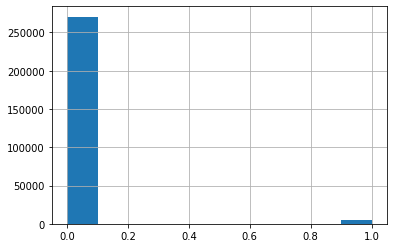

In [15]:
df['converted'].hist()

In [18]:
df['converted'].sum() / df['converted'].count()

0.018210118425635666

In [22]:
df['source'].unique()

[seo_facebook, seo-google, friend_referral, ads-google, ads-bing, ..., ads_other, seo-other, ads-yahoo, seo-yahoo, seo-bing]
Length: 12
Categories (12, object): [seo_facebook, seo-google, friend_referral, ads-google, ..., seo-other, ads-yahoo, seo-yahoo, seo-bing]

In [30]:
# set direct_traffic as the reference level for source and drop it because it's the most common
(df.groupby('source').count()['user_id'] / len(df)).sort_values(ascending=False)

source
direct_traffic     0.190823
ads-google         0.187130
ads_facebook       0.168223
ads_other          0.094639
seo-google         0.073134
ads-bing           0.072155
seo_facebook       0.067024
friend_referral    0.065348
seo-other          0.029236
ads-yahoo          0.023859
seo-yahoo          0.021628
seo-bing           0.006799
Name: user_id, dtype: float64

In [65]:
df['seo_source'] = df['source'].str.contains('seo').astype(int)
df['ads_source'] = df['source'].str.contains('ads').astype(int)
df['friend_referral_source'] = df['source'].str.contains('friend_referral').astype(int)

for company in ['bing', 'google', 'facebook', 'other', 'yahoo']:
    df[f'{company}_source'] = df['source'].str.contains(company).astype(int)

df = df.drop('source', axis=1)

In [34]:
df

,user_id,device,operative_system,lat,long,weekday,yearweek,converted,is_seo_source,is_ads_source,is_friend_referral_source,is_bing_source,is_google_source,is_facebook_source,is_other_source,is_yahoo_source
0,3,web,mac,38.89,-94.81,Friday,16,0,1,0,0,0,0,1,0,0
1,9,mobile,android,41.68,-72.94,Friday,18,0,1,0,0,0,1,0,0,0
2,14,mobile,iOS,39.74,-75.53,Saturday,13,0,0,0,1,0,0,0,0,0
3,16,mobile,android,37.99,-121.80,Friday,21,0,0,1,0,0,1,0,0,0
4,19,mobile,android,41.08,-81.52,Wednesday,14,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275611,999978,mobile,android,39.78,-86.15,Saturday,20,0,0,0,0,0,0,0,0,0
275612,999979,web,windows,31.10,-97.72,Friday,19,0,0,0,0,0,0,0,0,0
275613,999992,web,windows,40.77,-74.03,Saturday,19,0,0,1,0,0,0,1,0,0
275614,999993,web,windows,39.04,-95.69,Wednesday,11,0,0,1,0,0,0,1,0,0


In [21]:
# references = {}
# for col in dtypes['category']:
#     references[col] = df[col].cat.categories[0]

{'source': 'ads-bing',
 'device': 'mobile',
 'operative_system': 'android',
 'weekday': 'Friday'}

In [35]:
(df.groupby('device').count()['user_id'] / len(df)).sort_values(ascending=False)

device
mobile    0.588939
web       0.411061
Name: user_id, dtype: float64

In [67]:
def get_dummies_drop_level_and_join(df, column, level_to_drop):
    dummies = pd.get_dummies(df[column]).drop([level_to_drop], axis=1)
    return df.join(dummies).drop(column, axis=1)

In [68]:
df = get_dummies_drop_level_and_join(df, 'device', 'mobile')

In [69]:
df.columns

Index(['user_id', 'operative_system', 'lat', 'long', 'weekday', 'yearweek', 'converted', 'seo_source', 'ads_source', 'friend_referral_source', 'bing_source', 'google_source', 'facebook_source', 'other_source', 'yahoo_source', 'web'], dtype='object')

In [51]:
df.groupby('operative_system').count()[df.columns[0]]

operative_system
android    65305
iOS        82982
linux       3634
mac        21831
other      14143
windows    87721
Name: user_id, dtype: int64

In [36]:
(df.groupby('operative_system').count()['user_id'] / len(df)).sort_values(ascending=False)

operative_system
windows    0.318273
iOS        0.301078
android    0.236942
mac        0.079208
other      0.051314
linux      0.013185
Name: user_id, dtype: float64

In [70]:
df = get_dummies_drop_level_and_join(df, 'operative_system', 'windows')

In [38]:
(df.groupby('weekday').count()['user_id'] / len(df)).sort_values(ascending=False)

weekday
Friday       0.290429
Saturday     0.234500
Sunday       0.176013
Thursday     0.116782
Tuesday      0.062057
Monday       0.060671
Wednesday    0.059547
Name: user_id, dtype: float64

In [71]:
df = get_dummies_drop_level_and_join(df, 'weekday', 'Friday')

In [72]:
df['intercept'] = 1
df.columns

Index(['user_id', 'lat', 'long', 'yearweek', 'converted', 'seo_source', 'ads_source', 'friend_referral_source', 'bing_source', 'google_source', 'facebook_source', 'other_source', 'yahoo_source', 'web', 'android', 'iOS', 'linux', 'mac', 'other', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'intercept'], dtype='object')

In [73]:
get_types(df)

defaultdict(list,
            {'int64': ['user_id',
              'yearweek',
              'converted',
              'seo_source',
              'ads_source',
              'friend_referral_source',
              'bing_source',
              'google_source',
              'facebook_source',
              'other_source',
              'yahoo_source',
              'intercept'],
             'float64': ['lat', 'long'],
             'uint8': ['web',
              'android',
              'iOS',
              'linux',
              'mac',
              'other',
              'Monday',
              'Saturday',
              'Sunday',
              'Thursday',
              'Tuesday',
              'Wednesday']})

In [74]:
import statsmodels.api as sm
target = 'converted'
x = df.drop(target, axis=1)
logit = sm.Logit(data[target], x)
output = logit.fit()

Optimization terminated successfully.
         Current function value: 0.089610
         Iterations 20


In [81]:
def statsmodels_output_table(output):
    output_table = pd.DataFrame(dict(coefficients=output.params,
                             SE=output.bse, z=output.tvalues,
                             p_values=output.pvalues))
    significant = output_table.loc[output_table['p_values'] < 0.05].sort_values("coefficients", ascending=False)
    not_significant = output_table.loc[output_table['p_values'] >= 0.05].sort_values("coefficients", ascending=False)
    return significant, not_significant


sig, not_sig = statsmodels_output_table(output)

In [82]:
not_sig

,coefficients,SE,z,p_values
intercept,8.731873e+01,4.033611e+05,2.164778e-04,0.999827
google_source,2.890141e-01,4.721652e+05,6.121038e-07,1.000000
facebook_source,2.657388e-01,4.721652e+05,5.628089e-07,1.000000
ads_source,2.620440e-01,4.721652e+05,5.549838e-07,1.000000
seo_source,1.152199e-01,4.343288e+05,2.652828e-07,1.000000
yahoo_source,5.651968e-02,5.071868e+05,1.114376e-07,1.000000
Sunday,5.200830e-03,4.258393e-02,1.221313e-01,0.902795
user_id,2.618701e-08,4.946931e-08,5.293587e-01,0.596557
long,-1.136634e-04,8.010338e-04,-1.418959e-01,0.887162
yearweek,-7.423822e-04,3.814582e-03,-1.946169e-01,0.845693


In [83]:
sig

,coefficients,SE,z,p_values
friend_referral_source,1.161799,0.055770,20.832016,2.219225e-96
mac,0.375495,0.051292,7.320678,2.467215e-13
Tuesday,-0.144396,0.066174,-2.182061,2.910503e-02
linux,-0.727721,0.182421,-3.989236,6.628643e-05


In [ ]:
# That's odd that there are so few significant variables for the source levels. Did I divide the dummy variables
# for source too much? 

In [229]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1H_-mi6NzeZt1PhcanHofcf3H6UiItmxO')

In [202]:
def positive_pct_per_level(df, column, target):
    """
    Return count and % of positive class at all levels of feature.
    :param df:
    :param column:
    :return:
    """
    g = df[[column, target]].groupby(column).agg(['sum', 'count']).reset_index()
    target_pct = f"{target}_pct"
    g[target_pct] = g[target]['sum'] / g['converted']['count']
    g['frequency_pct'] = g['converted']['count'] / len(df)
    return g.sort_values(by=target_pct, ascending=False)

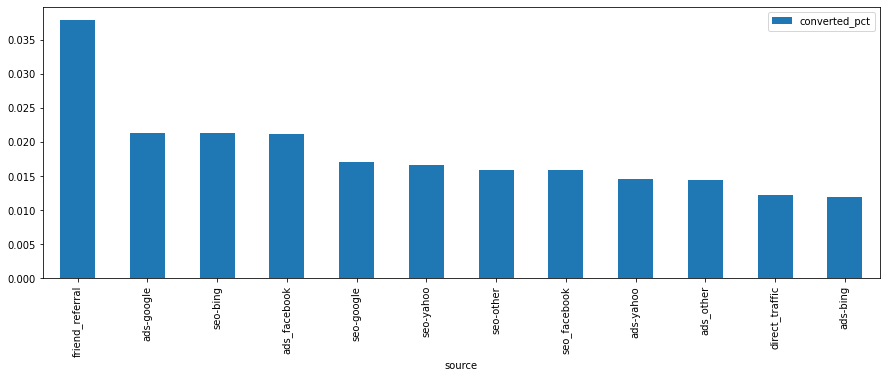

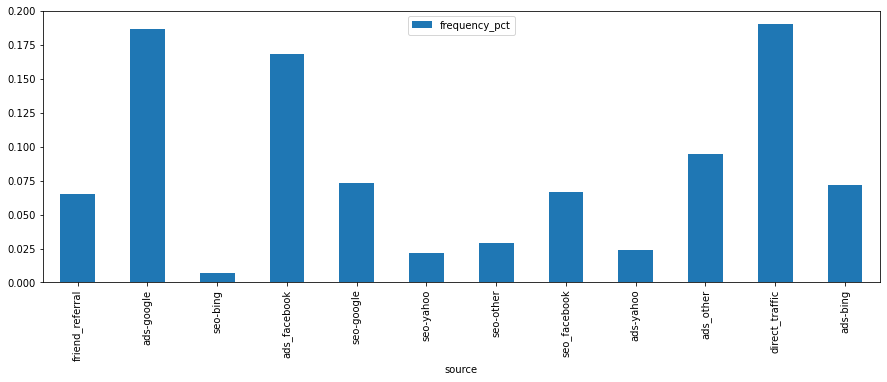

In [213]:
source = positive_pct_per_level(df, 'source', 'converted')
source.plot(x='source', y='converted_pct', kind='bar', figsize=(15, 5))
source.plot(x='source', y='frequency_pct', kind='bar', figsize=(15, 5))

In [214]:
dtypes

defaultdict(list,
            {'int64': ['user_id', 'yearweek', 'converted'],
             'category': ['source', 'device', 'operative_system', 'weekday'],
             'float64': ['lat', 'long']})

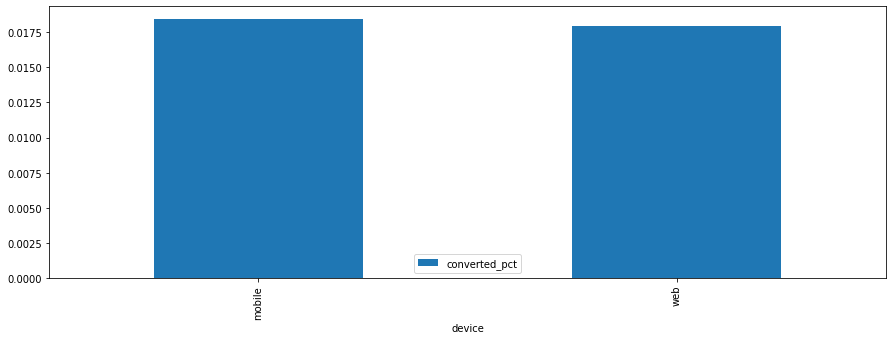

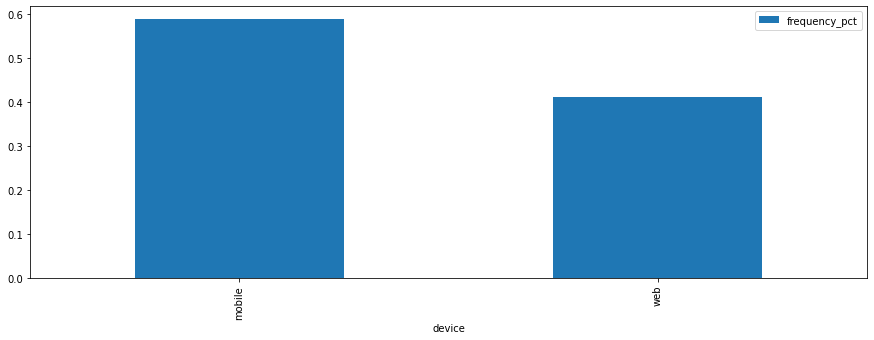

In [215]:
col = 'device'
stats = positive_pct_per_level(df, col, 'converted')
stats.plot(x=col, y='converted_pct', kind='bar', figsize=(15, 5))
stats.plot(x=col, y='frequency_pct', kind='bar', figsize=(15, 5))

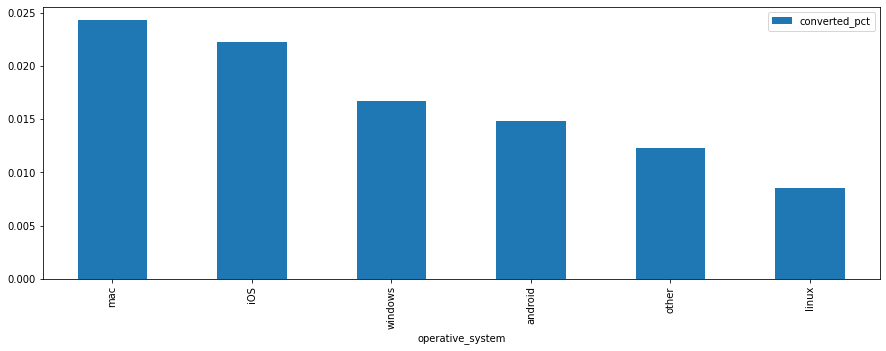

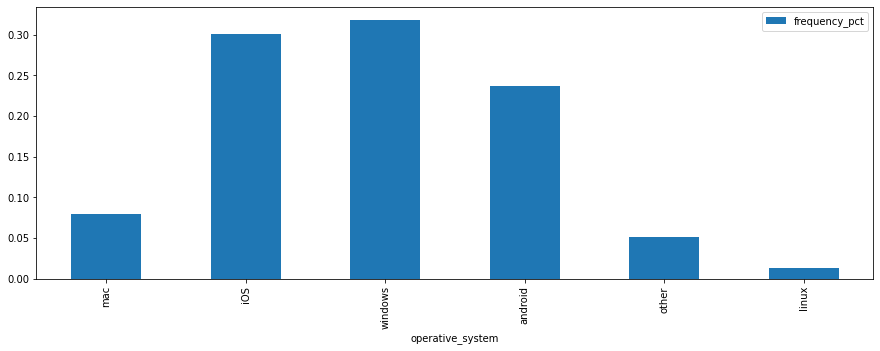

In [216]:
col = 'operative_system'
stats = positive_pct_per_level(df, col, 'converted')
stats.plot(x=col, y='converted_pct', kind='bar', figsize=(15, 5))
stats.plot(x=col, y='frequency_pct', kind='bar', figsize=(15, 5))

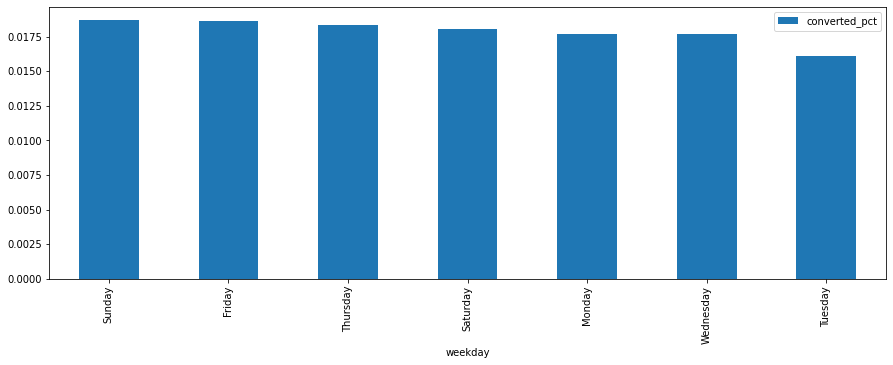

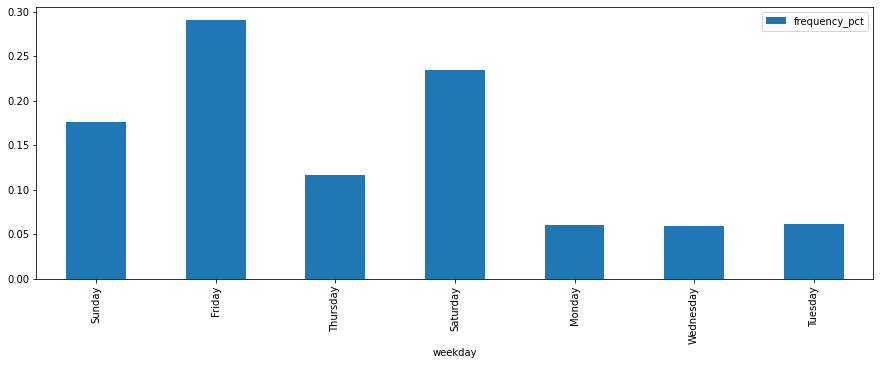

In [217]:
col = 'weekday'
stats = positive_pct_per_level(df, col, 'converted')
stats.plot(x=col, y='converted_pct', kind='bar', figsize=(15, 5))
stats.plot(x=col, y='frequency_pct', kind='bar', figsize=(15, 5))

In [87]:
def get_categorical_counts(df, column):
    return df.groupby(column).count()[df.columns[0]].sort_values(ascending=False)

get_categorical_counts(df, 'source')

source
direct_traffic     52594
ads-google         51576
ads_facebook       46365
ads_other          26084
seo-google         20157
ads-bing           19887
seo_facebook       18473
friend_referral    18011
seo-other           8058
ads-yahoo           6576
seo-yahoo           5961
seo-bing            1874
Name: user_id, dtype: int64

In [230]:
df = get_dummies_drop_level_and_join(df, 'source', 'direct_traffic')
df = get_dummies_drop_level_and_join(df, 'device', 'mobile')
df = get_dummies_drop_level_and_join(df, 'weekday', 'Friday')
df = get_dummies_drop_level_and_join(df, 'operative_system', 'windows')

In [89]:
df.columns

Index(['user_id', 'lat', 'long', 'yearweek', 'converted', 'ads-bing', 'ads-google', 'ads-yahoo', 'ads_facebook', 'ads_other', 'friend_referral', 'seo-bing', 'seo-google', 'seo-other', 'seo-yahoo', 'seo_facebook', 'web', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'android', 'iOS', 'linux', 'mac', 'other'], dtype='object')

In [224]:
x

,user_id,lat,long,yearweek,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook,web,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,android,iOS,linux,mac,other,intercept
0,3,38.89,-94.81,16,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1
1,9,41.68,-72.94,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,14,39.74,-75.53,13,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,16,37.99,-121.80,21,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,19,41.08,-81.52,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275611,999978,39.78,-86.15,20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
275612,999979,31.10,-97.72,19,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
275613,999992,40.77,-74.03,19,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
275614,999993,39.04,-95.69,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [234]:
target = 'converted'
# df['intercept'] = 1
x = df.drop(target, axis=1)
x['intercept'] = 1
print(x.columns)
y = df[target]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=random_state, test_size=.2, stratify=y)
logit = sm.Logit(ytrain.ravel(), xtrain)
output = logit.fit()

Index(['user_id', 'lat', 'long', 'yearweek', 'ads-bing', 'ads-google', 'ads-yahoo', 'ads_facebook', 'ads_other', 'friend_referral', 'seo-bing', 'seo-google', 'seo-other', 'seo-yahoo', 'seo_facebook', 'web', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'android', 'iOS', 'linux', 'mac', 'other', 'intercept'], dtype='object')
         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
Singular matrix

In [191]:
from sklearn.linear_model import LogisticRegression

# Test that LogisticRegression results are stable

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

scoring = {
    'r2': 'r2',
    'mean_squared_error': make_scorer(mean_squared_error)
}
scores = cross_validate(LogisticRegression(C=1e-8), x, y, scoring=scoring, cv=cv, return_train_score=True)
results = pd.DataFrame(scores)
results['mse_diff'] = results['test_mean_squared_error'] - results['train_mean_squared_error']
std = results['test_mean_squared_error'].std()
mean = results['test_mean_squared_error'].mean()
print(mean, std, std / mean)
results

0.018224631345814816 9.876908230985692e-06 0.0005419538010712008


,fit_time,score_time,test_r2,train_r2,test_mean_squared_error,train_mean_squared_error,mse_diff
0,0.681251,0.005977,-0.019566,-0.019308,0.018232,0.018223,0.000009
1,0.684089,0.005563,-0.020564,-0.019059,0.018232,0.018223,0.000009
2,0.674370,0.004803,-0.019566,-0.019308,0.018232,0.018223,0.000009
3,0.643502,0.004716,-0.018552,-0.019562,0.018214,0.018227,-0.000014
4,0.594272,0.005130,-0.018552,-0.019562,0.018214,0.018227,-0.000014


In [140]:
sig, not_sig = statsmodels_output_table(output)

In [141]:
not_sig

,coefficients,SE,z,p_values
ads-yahoo,1.849534e-01,1.102922e-01,1.676939,0.093554
Sunday,5.659854e-03,4.258681e-02,0.132902,0.894271
user_id,2.622364e-08,4.946945e-08,0.530098,0.596044
long,-1.074518e-04,8.012019e-04,-0.134113,0.893313
yearweek,-7.296307e-04,3.814514e-03,-0.191278,0.848308
lat,-5.310552e-03,2.768462e-03,-1.918232,0.055082
ads-bing,-1.545457e-02,7.642274e-02,-0.202225,0.839741
Thursday,-1.934941e-02,4.914974e-02,-0.393683,0.693815
Saturday,-3.006792e-02,3.950180e-02,-0.761178,0.446550
Wednesday,-4.748912e-02,6.486738e-02,-0.732095,0.464110


In [98]:
# set direct_traffic as the reference level for source and drop it because it's the most common
(df.groupby('source').count()['user_id'] / len(df)).sort_values(ascending=False)

source
direct_traffic     0.190823
ads-google         0.187130
ads_facebook       0.168223
ads_other          0.094639
seo-google         0.073134
ads-bing           0.072155
seo_facebook       0.067024
friend_referral    0.065348
seo-other          0.029236
ads-yahoo          0.023859
seo-yahoo          0.021628
seo-bing           0.006799
Name: user_id, dtype: float64

In [99]:
(df.groupby('source').count()['user_id']).sort_values(ascending=False)

source
direct_traffic     52594
ads-google         51576
ads_facebook       46365
ads_other          26084
seo-google         20157
ads-bing           19887
seo_facebook       18473
friend_referral    18011
seo-other           8058
ads-yahoo           6576
seo-yahoo           5961
seo-bing            1874
Name: user_id, dtype: int64

Now the number of coefficients makes more sense. 

friend_referral is the highest positive predictor of conversion. Find ways to increase the number of friend referrals, because they pay off.

Ads on google and facebook also do well. More data needed on whether the same ads are being shown on all platforms. If so, invest more into google and facebook ads and less into other ad platforms.

seo-bing does is a positive predictor, but it's hard to trust seo-bing, ads-yahoo, and seo-yahoo because there are so few observations.

Mac users are a low percentage of user base but have a high conversion rate. Lots of growth potential in that segment. Compared to windows, mac is more of a positive predictor. ios is a negative predictor and all other platforms are negative predictors. ios has a higher conversion rate than windows, so ios must be correlated with some other variable that negatively affects conversion rate.

Day of the week for the ad doesn't seem to matter. The Tuesday effect is probably noise.

In [132]:
not_sig

,coefficients,SE,z,p_values
ads-yahoo,1.849534e-01,1.102922e-01,1.676939,0.093554
Sunday,5.659854e-03,4.258681e-02,0.132902,0.894271
user_id,2.622364e-08,4.946945e-08,0.530098,0.596044
long,-1.074518e-04,8.012019e-04,-0.134113,0.893313
yearweek,-7.296307e-04,3.814514e-03,-0.191278,0.848308
lat,-5.310552e-03,2.768462e-03,-1.918232,0.055082
ads-bing,-1.545457e-02,7.642274e-02,-0.202225,0.839741
Thursday,-1.934941e-02,4.914974e-02,-0.393683,0.693815
Saturday,-3.006792e-02,3.950180e-02,-0.761178,0.446550
Wednesday,-4.748912e-02,6.486738e-02,-0.732095,0.464110


In [93]:
sig

,coefficients,SE,z,p_values
friend_referral,1.161836,0.055770,20.832740,2.185927e-96
ads-google,0.571586,0.050135,11.401017,4.132620e-30
ads_facebook,0.561917,0.051242,10.966021,5.566842e-28
seo-bing,0.558358,0.164788,3.388340,7.031695e-04
mac,0.375499,0.051297,7.320034,2.479074e-13
seo-google,0.341295,0.067482,5.057557,4.246618e-07
seo-yahoo,0.320600,0.108929,2.943206,3.248321e-03
seo_facebook,0.274673,0.071107,3.862831,1.120804e-04
seo-other,0.272132,0.097622,2.787608,5.309879e-03
ads_other,0.171098,0.065520,2.611384,9.017652e-03


In [130]:
g = df[['operative_system', 'converted']].groupby('operative_system').agg(['sum', 'count']).reset_index()
g['converted_pct'] = g['converted']['sum'] / g['converted']['count']
g.sort_values(by='converted_pct', ascending=False)

operative_system converted        converted_pct
                         sum  count              
3              mac       531  21831      0.024323
1              iOS      1847  82982      0.022258
5          windows      1467  87721      0.016723
0          android       969  65305      0.014838
4            other       174  14143      0.012303
2            linux        31   3634      0.008531

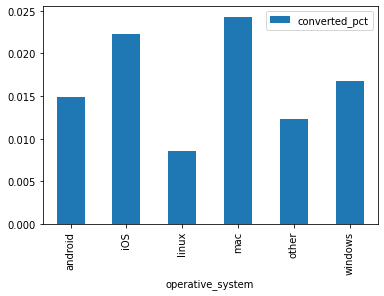

In [126]:
g.plot(x='operative_system', y='converted_pct', kind='bar')

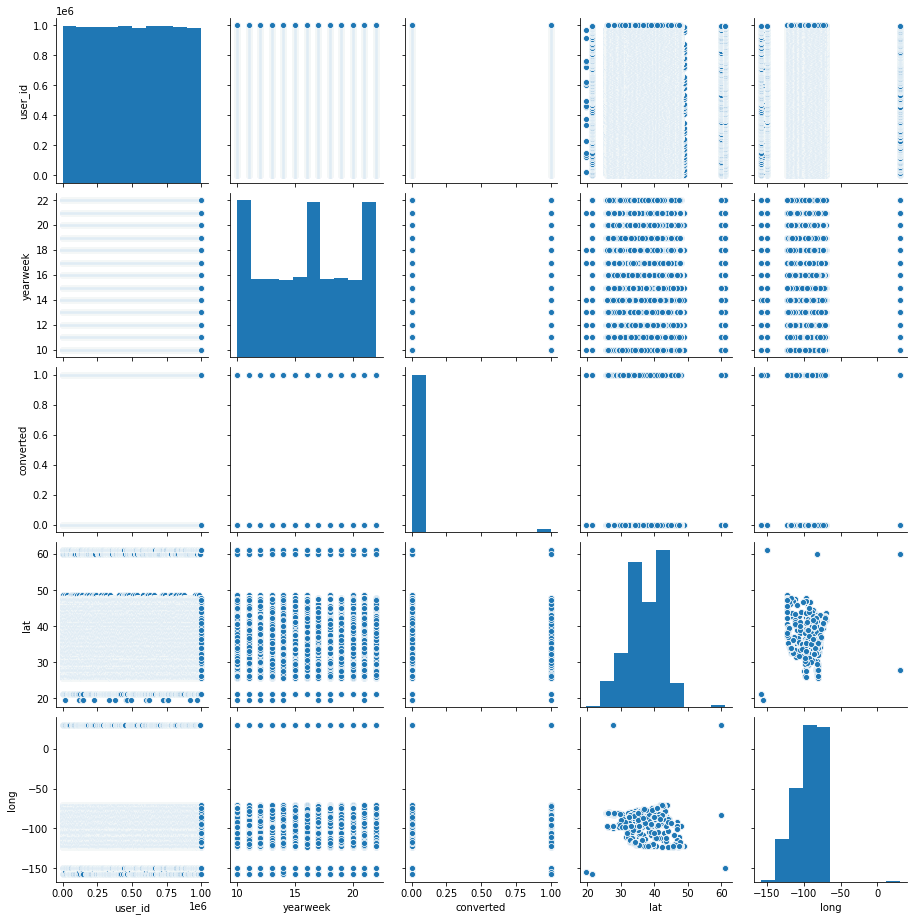

In [198]:
sns.pairplot(df[dtypes['int64'] + dtypes['float64']], size=2.5)

[]

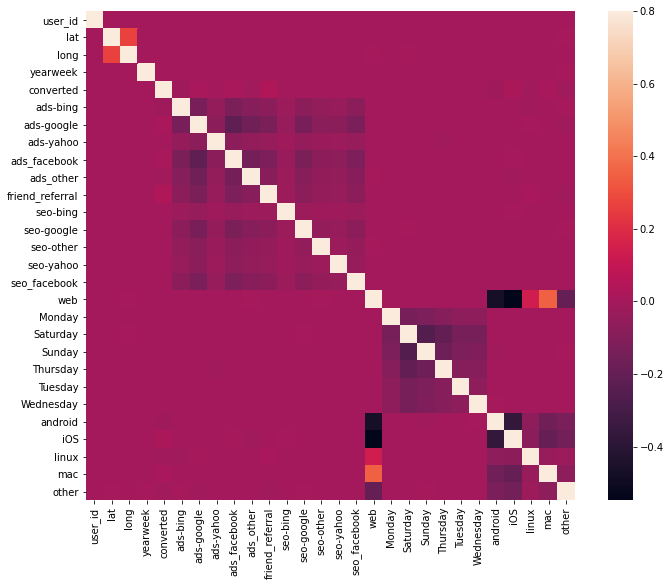

In [194]:
def correlation_heatmap(df, target=None, n_largest=None):
    f, ax = plt.subplots(figsize=(12, 9))
    # evidence for using both Kendall's Tau and Spearman's rho if the feature distributions are not
    # assumed to be normal: https://stats.stackexchange.com/questions/3943/kendall-tau-or-spearmans-rho
    # Some commenters say that Spearman's rho is more intepretable because it extends the idea of R^
    # in that it quantifies the difference between the % of concordant and discordant pairs among all
    # possible pairwise events.
    corrmat = df.corr(method='spearman')
    if n_largest is not None:
        cols = corrmat.nlargest(n_largest, target)  [target].index
        cm = np.corrcoef(df[cols].values.T)
        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                    xticklabels=cols.values)
    else:
        cols = []
        sns.heatmap(corrmat, vmax=.8, square=True)

    return cols


correlation_heatmap(df, target)

In [241]:
len(xtrain) == len(ytrain)

True

In [238]:
clf = XGBClassifier(min_child_weight=5)
scoring = {
    'r2': 'r2',
    'recall': 'recall',
    'precision': 'precision'
}
scores = cross_validate(clf, xtrain, ytrain, scoring=scoring, cv=cv, return_train_score=True)
results = pd.DataFrame(scores)
results['recall_diff'] = results['test_recall'] - results['train_recall']
std = results['test_recall'].std()
mean = results['test_recall'].mean()
print(mean, std, std / mean)
results

0.0 0.0 nan


,fit_time,score_time,test_r2,train_r2,test_recall,train_recall,test_precision,train_precision,recall_diff
0,3.917832,0.068186,-0.018547,-0.018547,0.0,0.000000,0.0,0.0,0.000000
1,4.080844,0.071351,-0.018547,-0.018230,0.0,0.000311,0.0,1.0,-0.000311
2,4.180117,0.070633,-0.018547,-0.017913,0.0,0.000623,0.0,1.0,-0.000623
3,4.303739,0.079184,-0.018547,-0.018547,0.0,0.000000,0.0,0.0,0.000000
4,5.011508,0.077154,-0.018547,-0.018230,0.0,0.000311,0.0,1.0,-0.000311


In [ ]:
plot_partial_dependence

In [242]:
clf.fit(xtrain, ytrain)

NameError: name 'recall' is not defined

In [257]:
np.sum(ytrain) / len(ytrain)

0.018209277434101917

In [251]:
pred = clf.predict(xtest)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [253]:
np.unique(pred)

array([0])

In [244]:
precision_score(ytest, clf.predict(xtest))

0.0